In [1]:
import numpy as np
import tensorflow as tf

## Setting up a simple meta-learning environment

First, we set up a meta-learning environment from which we can generate tasks/datasets for meta-training and meta-testing. In particular, we use sinusoid functions with random amplitude and phase shift. Each task corresponds to a sinusoidal function $f_{a,b}(x)$, given as follows:

$$ f_{a,b}(x) = a \sin(x-b) + 5, ~\text{with}~~ a \sim \mathit{U}(2, 4), b \sim \mathit{U}(-2, 2)$$

Given $f_{a,b}(x)$, the data $S = \{(x_1, y_1), ...., (x_m, y_m) \}$ is generated as follows:

$$x_j \sim \mathit{U}(-4, 4), y = f_{a,b}(x_j)) + \epsilon_j ~, ~~ \epsilon_j \sim \mathcal{N}(0, 0.1^2) ~~ \text{for} ~j= 1, ..., m$$

In [2]:
class SinusoidEnv():
    
    def __init__(self, amp_low=2.0, amp_high=4.0, x_shift_low=-2.0, x_shift_high=2.0,
                 x_low=-4.0, x_high=4.0, noise_std=0.1, seed=234):
        self.amp_low = amp_low
        self.amp_high = amp_high
        self.x_shift_low = x_shift_low
        self.x_shift_high = x_shift_high
        self.x_low = x_low
        self.x_high = x_high
        self.noise_std = noise_std
        self.random_state = np.random.RandomState(seed)

    def _sample_sinusoid_fn(self):
        amplitude = np.random.uniform(self.amp_low, self.amp_high)
        x_shift = np.random.uniform(self.x_shift_low, self.x_shift_high)
        return lambda x: amplitude * np.sin((x - x_shift)) + 5.0

    def generate_meta_train_data(self, n_tasks, n_samples):
        meta_train_tuples = []
        for i in range(n_tasks):
            f = self._sample_sinusoid_fn()
            X = self.random_state.uniform(self.x_low, self.x_high, size=(n_samples, 1))
            Y = f(X) + self.noise_std * self.random_state.normal(size=f(X).shape)
            meta_train_tuples.append((X, Y))
        return meta_train_tuples

    def generate_meta_test_data(self, n_tasks, n_samples_context, n_samples_test):
        assert n_samples_test > 0
        meta_test_tuples = []
        for i in range(n_tasks):
            f = self._sample_sinusoid_fn()
            X = self.random_state.uniform(self.x_low, self.x_high, size=(n_samples_context + n_samples_test, 1))
            Y = f(X) + self.noise_std * self.random_state.normal(size=f(X).shape)
            meta_test_tuples.append(
                (X[:n_samples_context], Y[:n_samples_context], X[n_samples_context:], Y[n_samples_context:]))

        return meta_test_tuples

### Generate meta-train and meta-test data

For each task the learner gets only 5 training points. For evaluation, we use 200 points.

In [3]:
env = SinusoidEnv()
meta_train_data = env.generate_meta_train_data(n_tasks=100, n_samples=5)
meta_test_data = env.generate_meta_test_data(n_tasks=20, n_samples_context=5,n_samples_test=200)

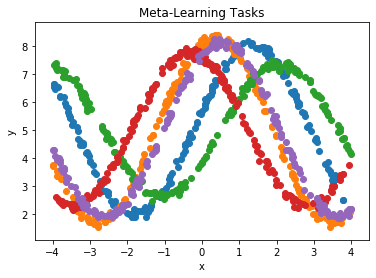

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
for x_context, y_context, x_test, y_test in meta_test_data[:5]:
    plt.scatter(x_test, y_test)
plt.title('Meta-Learning Tasks')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Training a Standard Bayesian Neural Network 

Now, we train a standard Bayesian Neural Network (BNN) with zero-centered, sperical Gaussian prior $P(\theta) = \mathcal{N}(0, \sigma_P^2 \mathbf{I})$.

100%|██████████| 500/500 [00:03<00:00, 164.63it/s, loss=40.9, avg_ll=-50.2, avg_rmse=2.49, cal_err=0.216]


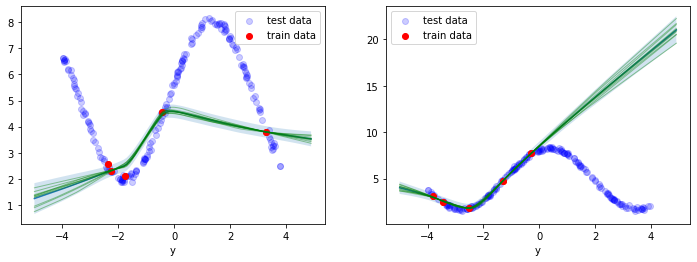

In [5]:
import warnings
import warnings
warnings.filterwarnings("ignore")

from pacoh_nn.bnn import BayesianNeuralNetworkSVGD

fig, axes = plt.subplots(1, 2, figsize=(12.0, 4.0))
for i in range(2):
    x_context, y_context, x_test, y_test = meta_test_data[i]
    
    # setting up and fitting the BNN
    bnn = BayesianNeuralNetworkSVGD(x_context, y_context, hidden_layer_sizes=(64, 64), prior_weight=0.001, bandwidth=1000.0)
    bnn.fit(x_val=x_test, y_val=y_test, num_iter_fit=500, log_period=500)
    
    # plotting
    x_plot = tf.range(-5, 5, 0.1)
    bnn.plot_predictions(x_plot, ax=axes[i])
    axes[i].scatter(x_test, y_test, color='blue', alpha=0.2, label="test data")
    axes[i].scatter(x_context, y_context, color='red', label="train data")
    axes[i].legend()
    axes[i].set_xlabel('x')
    axes[i].set_xlabel('y')

fig.show()

Since this prior is pretty uninformative, it provides poor inductive bias. As we can see in the plots below, the learned posterior prediction do not generalize well beyond the training data. Moreover, the majority of test points lie outside the confidence regions of the posterior, indicating poorly calibrated uncertainty estimates.

## Meta-Learning a BNN Prior with PACOH-NN

### Meta-Training

Now, we use PACOH-NN to meta-learn a prior that exhibits the inductive bias our sinusoidal environment. During the meta-training process, we plot functions sampled from the (learned) prior to visually inspect how the prior evolves.

Start meta-training -------------------- 


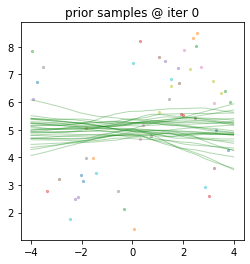


Iter 0/20000 - Time 37.05 sec - Train-Loss: -12694.16113

Iter 1000/20000 - Time 22.04 sec - Train-Loss: -368.68948

Iter 2000/20000 - Time 21.85 sec - Train-Loss: -768.29926

Iter 3000/20000 - Time 17.80 sec - Train-Loss: -374.42398

Iter 4000/20000 - Time 16.42 sec - Train-Loss: -416.99927


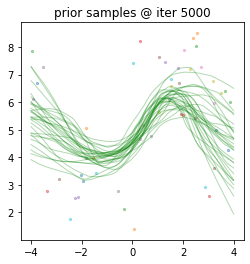

	Start meta-test posterior inference in 2 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----
	Meta-Test - Iter 0/3000 - Time 25.73 sec - Train-Log-Prob: 4781.656

	 Iter 0/3000 - Time 5.10 sec - Val-avg_ll: -23.274 +- 21.200- Val-avg_rmse: 1.884 +- 0.607- Val-cal_err: 0.200 +- 0.033
	Meta-Test - Iter 1000/3000 - Time 29.20 sec - Train-Log-Prob: -79.254

	 Iter 1000/3000 - Time 0.37 sec - Val-avg_ll: -19.912 +- 24.112- Val-avg_rmse: 1.488 +- 0.840- Val-cal_err: 0.222 +- 0.063
	Meta-Test - Iter 2000/3000 - Time 26.43 sec - Train-Log-Prob: -85.463

	 Iter 2000/3000 - Time 0.41 sec - Val-avg_ll: -19.250 +- 22.459- Val-avg_rmse: 1.452 +- 0.837- Val-cal_err: 0.228 +- 0.067
	Meta-Test batch #2 consisting of 5 tasks----
	Meta-Test - Iter 0/3000 - Time 24.99 sec - Train-Log-Prob: 9235.702

	 Iter 0/3000 - Time 5.14 sec - Val-avg_ll: -98.497 +- 165.074- Val-avg_rmse: 2.043 +- 0.575- Val-cal_err: 0.211 +- 0.015
	Meta-Test - Iter 1000/3000 - Time 27.38 sec - Train-Log-Prob: -

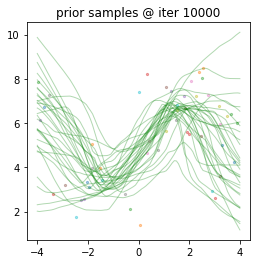

	Start meta-test posterior inference in 2 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----
	Meta-Test - Iter 0/3000 - Time 23.92 sec - Train-Log-Prob: -55.785

	 Iter 0/3000 - Time 4.47 sec - Val-avg_ll: -2.486 +- 0.857- Val-avg_rmse: 1.816 +- 0.744- Val-cal_err: 0.126 +- 0.054
	Meta-Test - Iter 1000/3000 - Time 27.55 sec - Train-Log-Prob: -91.765

	 Iter 1000/3000 - Time 0.45 sec - Val-avg_ll: -1.490 +- 0.748- Val-avg_rmse: 1.071 +- 0.504- Val-cal_err: 0.164 +- 0.077
	Meta-Test - Iter 2000/3000 - Time 26.19 sec - Train-Log-Prob: -92.953

	 Iter 2000/3000 - Time 0.62 sec - Val-avg_ll: -1.476 +- 0.726- Val-avg_rmse: 1.052 +- 0.502- Val-cal_err: 0.167 +- 0.078
	Meta-Test batch #2 consisting of 5 tasks----
	Meta-Test - Iter 0/3000 - Time 23.47 sec - Train-Log-Prob: -55.415

	 Iter 0/3000 - Time 5.51 sec - Val-avg_ll: -2.697 +- 1.178- Val-avg_rmse: 2.064 +- 0.705- Val-cal_err: 0.138 +- 0.042
	Meta-Test - Iter 1000/3000 - Time 27.63 sec - Train-Log-Prob: -91.787

	 I

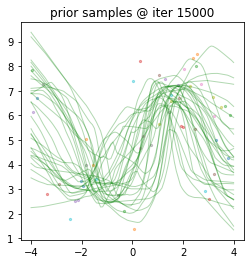

	Start meta-test posterior inference in 2 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----
	Meta-Test - Iter 0/3000 - Time 24.47 sec - Train-Log-Prob: -37.447

	 Iter 0/3000 - Time 4.68 sec - Val-avg_ll: -2.062 +- 0.540- Val-avg_rmse: 1.825 +- 0.804- Val-cal_err: 0.125 +- 0.022
	Meta-Test - Iter 1000/3000 - Time 30.89 sec - Train-Log-Prob: -72.566

	 Iter 1000/3000 - Time 0.42 sec - Val-avg_ll: -1.304 +- 0.307- Val-avg_rmse: 0.886 +- 0.351- Val-cal_err: 0.135 +- 0.048


KeyboardInterrupt: 

In [7]:
from pacoh_nn.pacoh_nn_regression import PACOH_NN_Regression
pacoh_model = PACOH_NN_Regression(meta_train_data, random_seed=22, num_iter_meta_train=20000,
                                     learn_likelihood=True, likelihood_std=0.1)

pacoh_model.meta_fit(meta_test_data[:10], eval_period=5000, log_period=1000, 
                        plot_prior_during_training=True, plot_period=5000)

As we can see in the plots this is actually the case. Throughout the process of meta-training, PACOH-NN meta-learns inductive bias towards sinusoidal function shapes.

### Meta-Testing

Finally, we perform meta-testing to see whether our meta-learned prior actually improves the BNN posterior predictions.

In [ ]:
pacoh_model.num_iter_meta_test = 3000
pacoh_model.prior_weight = 0.01
fig, axes = plt.subplots(1, 2, figsize=(12.0, 4.0))
for i in range(2):
    x_context, y_context, x_test, y_test = meta_test_data[i]
    
    # plotting
    x_plot = tf.range(-5, 5, 0.1)
    pacoh_model.plot_posterior(x_context, y_context, x_plot, ax=axes[i])
    axes[i].scatter(x_test, y_test, color='blue', alpha=0.2, label="test data")
    axes[i].scatter(x_context, y_context, color='red', label="train data")
    axes[i].legend()
    axes[i].set_xlabel('x')
    axes[i].set_xlabel('y')

fig.show()

eval_metrics_mean, eval_metrics_std = pacoh_model.meta_eval_datasets(meta_test_data)
for key in eval_metrics_mean:
    print("%s: %.4f +- %.4f"%(key, eval_metrics_mean[key], eval_metrics_std[key]))

Now the posterior prediction generalize much better beyond the training data. 
Moreover, the confidence intervals of the posterior contain the test points. 
Overall, this suggests that the meta-learned prior conveys useful inductive bias.